In [8]:
from skimage import io,filters, morphology, measure, draw,exposure
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.filters import threshold_otsu
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.optimize import curve_fit
from matplotlib import cm
from skimage.filters import threshold_multiotsu
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from tqdm import tqdm
from ome_types import from_tiff
import matplotlib

In [1]:
PATH = '<PATH/TO/DIR>/WAVE/Single_molecule_tracking/'

In [2]:
def f_x(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [3]:
# calculate MSD per nx delta t
def calculate_msd_under_n_deltaT(table,n):
    msd = []
    dt= 0
    for i in range(0,table.Frame.max()-n,n):
        back = table[table['Frame']==table.Frame.min()+i]
        forward = table[table['Frame']==table.Frame.min()+i+n]
        if len(back)!=0 and len(forward)!=0:
            dt = forward['T'].iloc[0]-back['T'].iloc[0]
            #Xs and Ys are half because the pixel size in the configuration file for the 100x object on the scope used is off by 2-fold. 
            msd.append(np.power(forward.X.iloc[0]*0.5-back.X.iloc[0]*0.5,2)+np.power(forward.Y.iloc[0]*0.5-back.Y.iloc[0]*0.5,2))
    return np.mean(msd),dt

In [ ]:
def compute_2D_diffussion_coefficient(table,spot_id):
    k = []
    for ID in spot_id:
        cur = table[table['Track ID']==ID]
        cur = cur.sort_values(by = ['T'],ascending=True)
        if len(cur)>=8:
            msd_1,dt_1 = calculate_msd_under_n_deltaT(cur,1)
            msd_2,dt_2 = calculate_msd_under_n_deltaT(cur,2)
            msd_3,dt_3 = calculate_msd_under_n_deltaT(cur,3)           
            msd_4,dt_4 = calculate_msd_under_n_deltaT(cur,4)
            if dt_4 != 0 and dt_3 != 0 and dt_2 !=0 and dt_1 !=0:
                popt, pcov = curve_fit(f_x, [dt_1,dt_2,dt_3,dt_4],[msd_1,msd_2,msd_3,msd_4]) 
                k.append(popt[0]/4)
    return k

# Compute diffussion coefficient

In [16]:
# Select single Sra1 molecules at the cell periphery only
SRA1_periphery_id = [[3,122,354,453,531,538,640,665],
                     [1,2,3,8,14,16,48,49,59,109,130,169,179,190,229,232,252,255,257,259,267,284,300,318,324,334,346,391,421,445,612,630],
                     [152,94,622,274,495,224,111],
                     [199,6,56,210,555,213,7,72,109,58,177,202,45,143,147,149,95,111,240,33,115,139,181],
                     [170,434,30,123,56,7,366,178,96,275,323,37,23,325,156,332],
                     [531,7,147,127,135,1,843,161,100,94],
                     [119,35,8,124,277,120,3,218,361,203,156],
                     [277,195,43,244,334,100,110,310],
                     [87,185,92,232,210,24,144,260,14,69],
                     [1,22,156,237,413,230,7,445,102,54,112,468,104,213,32,64,484,89],
                     [161,231,67,83,363,129,112,109,97],
                     [75,208,181,299]
                    ]

In [17]:
n = 0
for id in SRA1_periphery_id:
    n += len(SRA1_periphery_id)

In [34]:
sra_msd = []
for i in range(1,13):
    sra = pd.read_csv(PATH + 'Halo-sra1/spots_info/240117_Halo-sra1_0.05nM_549_p8_15ms_'+ str(i)+'_MMStack_Default.ome_allspots.csv',index_col=1,skiprows=[0,1,3])
    sra_id = SRA1_periphery_id[i-1]
    sra_msd.append(compute_2D_diffussion_coefficient(sra,sra_id))

/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [35]:
ave_sra1 = []
for k in sra_msd:
    ave_sra1.append(np.mean(k))

In [36]:
ave_sra1

[0.016646729751264147,
 0.006208687307628807,
 0.06943088219537942,
 0.010805866868892688,
 0.004399877231043048,
 0.007446330886662305,
 0.005507146087906464,
 0.014729584109142917,
 0.00296384607850637,
 0.00837538599791255,
 0.01717774325766278,
 0.00069429237152329]

In [38]:
with open(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1.csv', 'w') as f:
    for line in sra_msd:
        f.write(f"{line}\n")

In [39]:
with open(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1_ave.csv', 'w') as f:
    for line in ave_sra1:
        f.write(f"{line}\n")

In [40]:
# Load tracking info csv files generated from Fiji TrackMate
path = PATH + 'Controls/spots_info/'
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
dataframes = []
for csv_file in csv_files:
    df = pd.read_csv(path+"/"+csv_file,index_col=1,skiprows=[0,1,3])
    dataframes.append(df)
CAAX = dataframes

In [42]:
k_caax = []
for caax in tqdm(CAAX):
    k_caax.append(compute_2D_diffussion_coefficient(caax,np.unique(caax['Track ID'])))

  4%|█▊                                          | 1/24 [00:06<02:40,  6.97s/it]/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/muziyue/.pyenv/versions/3.8.16/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 24/24 [05:20<00:00, 13.34s/it]


In [46]:
ave_caax = []
for k in k_caax:
    ave_caax.append(np.mean(k))

In [47]:
with open(PATH + 'Controls/csv_data/diffusion_coefficient_caax_ave.csv', 'w') as f:
    for line in ave_caax:
        f.write(f"{line}\n")

In [48]:
with open(PATH + 'Controls/csv_data/diffusion_coefficient_caax.csv', 'w') as f:
    for line in k_caax:
        f.write(f"{line}\n")

# Generate plot

In [49]:
diffusion_Sra1 = pd.DataFrame()
diffusion_CAAX = pd.DataFrame()

In [50]:
diffusion_CAAX= pd.read_csv(PATH + 'Controls/csv_data/diffusion_coefficient_caax_ave.csv',names = ['CAAX'])
diffusion_Sra1= pd.read_csv(PATH + 'Halo-sra1/csv_data/diffusion_coefficient_sra1_periphery_ave.csv',names= ['Sra1'])

In [51]:
result = diffusion_Sra1
result = result.append(diffusion_CAAX)

/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_67015/2454992156.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result = result.append(diffusion_CAAX)


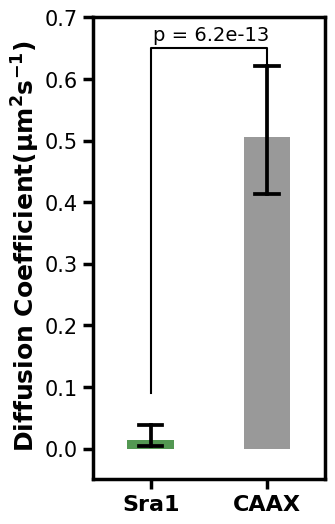

In [81]:
fig,ax = plt.subplots(figsize=(3,6))
sns.barplot(result,width = 0.4,errorbar=('ci', 100),errcolor = 'black', capsize = 0.2,palette = ['#48a446','#999999'])

plt.xlim(-0.5,1.5)
plt.ylim(-0.05,0.7)
plt.tick_params('x',labelsize = 16)
fig.text(-0.15, 0.5, r'Diffusion Coefficient($\mathbf{µm^{2}s^{-1}}$)', va='center', rotation='vertical',size = 18, fontweight = 'bold', usetex=False)
t = ttest_ind(result['Sra1'].dropna(),result['CAAX'].dropna())
y, h, col = 0.59, 0.06, 'k'
plt.plot([0, 0, 1,1], [y-0.5, y+h, y+h, y+0.03], lw=1.5, c=col)
fig.text(0.52, y+h+0.185, f"p = {t[1]:.2g}", ha='center', va='bottom', color=col,size = 14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2.5)
plt.yticks(fontsize = 15)
# increase tick width
ax.tick_params(width=2.5,size = 7)
plt.xticks(weight = 'bold')
plt.savefig(PATH + 'Fig3H_diffusion_coefficient.jpg',dpi = 300,bbox_inches = 'tight')

# Calculate frames per second

In [54]:
Sra1_delta_t = pd.read_csv(PATH + 'Halo-sra1/csv_data/delta_t.csv',names=['Sra1'])
CAAX_delta_t = pd.read_csv(PATH + 'Controls/csv_data/delta_t.csv',names=['CAAX'])

In [55]:
CAAX_fps = 1000/CAAX_delta_t
Sra1_fps = 1000/Sra1_delta_t

In [56]:
fps = Sra1_fps
fps = fps.append(CAAX_fps)

/var/folders/6k/52mtw9p52zqbjc64b8h01bgc0000gn/T/ipykernel_67015/1148541610.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fps = fps.append(CAAX_fps)


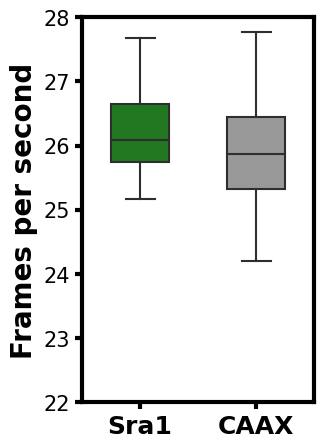

In [57]:
_,ax = plt.subplots(figsize = (3,5))
sns.boxplot(fps,width = 0.5,palette = ['#138613','#999999'])
plt.ylabel('Frames per second',size = 20,fontweight='bold')
plt.xticks(fontsize = 18)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.yticks(fontsize = 15)
# increase tick width
ax.tick_params(width=3,size = 5)
plt.xticks(weight = 'bold')
plt.ylim(22,28)
plt.savefig(PATH + "FigS2D_fps.png",dpi = 300,bbox_inches = 'tight')

# Plot kymographs

In [58]:
image = io.imread(PATH + 'Controls/example_images/kymo_1.tif')

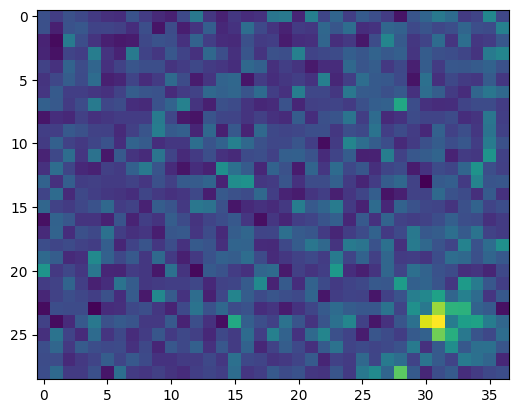

In [59]:
plt.imshow(image[0])

In [60]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

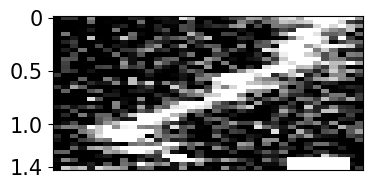

In [62]:
plt.figure(figsize = (4,2))
plt.imshow(kymograph,vmin = 15100,vmax= 15800, cmap='Greys_r',aspect = 'auto')
# plt.axis('off')
for i in range(36,37):
    plt.hlines(i,27.5,35,colors='white',lw = 10)
plt.yticks(ticks = [0,13.15,26.31,36.84],labels=[0,0.5,1.0,1.4],size = 15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.savefig(PATH + 'Fig3G_CAAX_kymo_1.png',dpi = 300,bbox_inches = 'tight')

In [63]:
image = io.imread(PATH + 'Controls/example_images/kymo_2.tif')

In [64]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

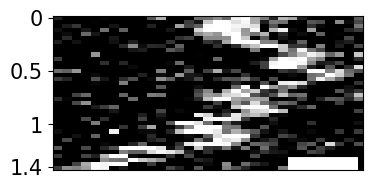

In [65]:
plt.figure(figsize = (4,2))
plt.imshow(kymograph,vmin = 18900,vmax= 19500, cmap='Greys_r',aspect= 'auto')
# plt.axis('off')
plt.yticks(ticks = [0,13.15,26.31,36.84],labels=[0,0.5,1,1.4],size = 15)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
for i in range(36,37):
    plt.hlines(i,24.5,32,colors='white',lw = 10)
plt.savefig(PATH + 'Fig3G_CAAX_kymo_2.png',dpi = 300,bbox_inches = 'tight')

In [70]:
image = io.imread(PATH + 'Halo-sra1/example_images/kymo_1.tif')

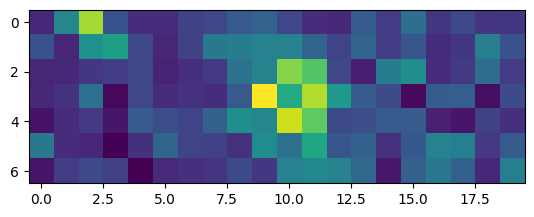

In [71]:
plt.imshow(image[0])

In [72]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

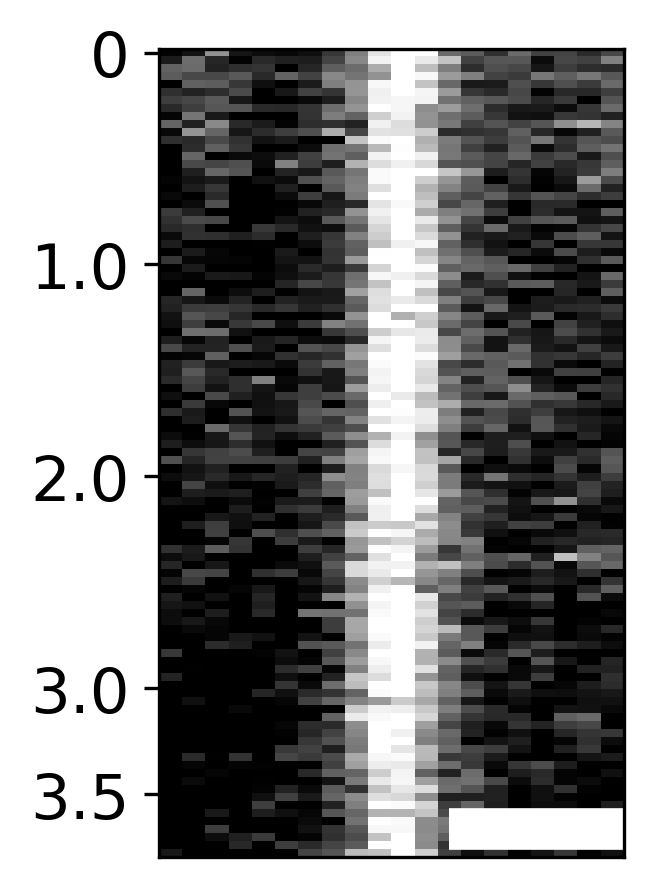

In [73]:
fig, ax = plt.subplots(figsize=(2,3.5),dpi = 300)
plt.imshow(kymograph, vmin = 3750,vmax = 4750,cmap='Greys_r', aspect='auto')
# plt.axis('off')
# plt.xticks(ticks = [0,3.83,7.66,11.49],labels=[0,0.5,1.0,1.5])
plt.yticks(ticks = [0,26.47,52.93,79.41,92.64],labels=[0,1.0,2.0,3.0,3.5],size = 18)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
for i in range(97,98):
    plt.hlines(i,12,19.5,colors='white',lw = 10)
# plt.colorbar()
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig(PATH + 'Fig3F_Sra1_kymo_1.png',dpi = 300,bbox_inches = 'tight')

In [77]:
image = io.imread(PATH + 'Halo-sra1/example_images/kymo_2.tif')

In [78]:
# Projection on the x axis
kymograph = []
for i in range(len(image)):
    kymograph.append(np.sum(image[i], axis = 0))

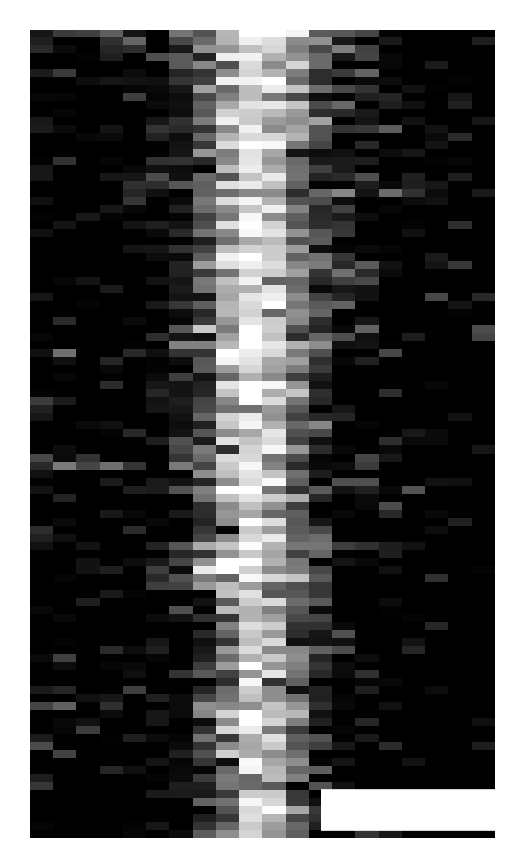

In [80]:
fig, ax = plt.subplots(figsize=(2,3.5),dpi = 300)
plt.imshow(kymograph, vmin = 3750,vmax = 4550,cmap='Greys_r', aspect='auto')
plt.axis('off')
# plt.xticks(ticks = [0,3.83,7.66,11.49],labels=[0,0.5,1.0,1.5])
# plt.yticks(ticks = [0,26.47,52.93,79.41,92.64],labels=[0,1.0,2.0,3.0,3.5],size = 18)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
for i in range(97,98):
    plt.hlines(i,12,19.5,colors='white',lw = 10)
# plt.colorbar()
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.savefig(PATH + 'Fig3F_Sra1_kymo_2.png',dpi = 300,bbox_inches = 'tight')